In [37]:
%load_ext autoreload
%autoreload 2
# System imports
import copy
import numpy as np
import time
import itertools
import os
import tempfile
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.system.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.system.chip as chip
import c3.signal.pulse as pulse
import c3.system.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils
import examples.two_qubit_chip_exp
import examples.single_qubit_rabi12
import useful
from scipy.optimize import minimize_scalar
from c3.optimizers.c1 import C1
import c3.libraries.algorithms as algorithms

#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

import matplotlib
import time

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution
#tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


In [38]:
exp = examples.single_qubit_rabi12.create_experiment()
exp2 = examples.single_qubit_rabi12.create_experiment(gatetime=20e-9, anhar=-1e7)

In [39]:
psi_init = [[0] * 3]
psi_init[0][0] = 1

init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)
pi01_seq = ['PI01p']
rx90_seq = ['RX90p']
rx_seq = ['RXp']
rabi12_seq = ['RXp','RX90p12','RX90p12']

tf.Tensor(
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(3, 1), dtype=complex128)


In [40]:
#TODO change amplitude gauss here in loop

amps = np.arange(0.1,1,1)

[9.70357539e-01 2.96368626e-02 5.59878166e-06]


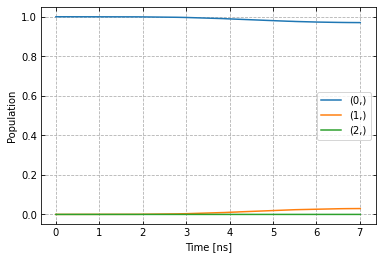

In [50]:
for amp in amps:
    exp.change_pi_amp(amp)
    exp.get_gates()
    t,pop = useful.plot_dynamics(exp, init_state, pi01_seq)
    print(pop[-1])

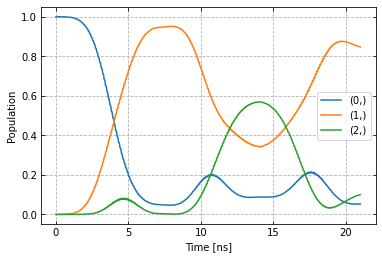

In [42]:
exp.get_gates()
_,_ = useful.plot_dynamics(exp, init_state, rabi12_seq)


In [43]:
exp.pmap.instructions['Id'].t_end

7e-09

In [44]:
exp.evaluate([pi01_seq],init_state)

[<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
 array([[9.70357539e-01],
        [2.96368626e-02],
        [5.59878166e-06]])>]

In [47]:
opt_gates = ["RXp"]
gateset_opt_map=[
    [
      ("RXp", "d1", "gauss", "amp"),
    ],
    [
      ("RXp", "d1", "gauss", "freq_offset"),
    ],
    [
      ("RXp", "d1", "gauss", "xy_angle"),
    ],
    [
      ("RXp", "d1", "gauss", "delta"),
    ]
]
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = C1(
    dir_path=log_dir,
    fid_func=fidelities.average_infid_set,
    fid_subspace=["Q1"],
    pmap=exp.pmap,
    algorithm=algorithms.lbfgs,
    options={"maxfun" : 10},
    run_name="better_RX"
)
exp.pmap.set_opt_map(gateset_opt_map)
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)

opt.optimize_controls()
print(opt.current_best_params)
print(opt.current_best_goal)


C3:STATUS:Saving as: C:\Users\flori\AppData\Local\Temp\tmp7acl0wb2\c3logs\better_RX\2021_04_30_T_13_00_35\open_loop.log
[0.8999996737614795, -50552376.20129063, 0.049580372884035384, -0.8525682446864282]
0.007049359776818975


After opt

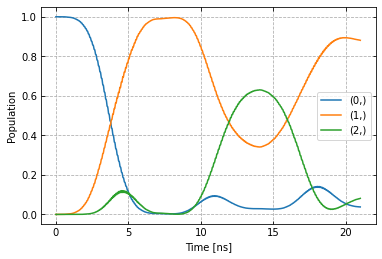

In [49]:
_,_ = useful.plot_dynamics(exp, init_state, rabi12_seq)